In [1]:
import pybaseball
import pandas as pd
import numpy as np
import bs4
import requests
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns
import math
import matplotlib.patches as mpatches
from IPython.display import display
pybaseball.cache.enable()

In [2]:
import os
pd.set_option('display.max_columns',None)
os.getcwd()
os.chdir('C:\\Users\\npacchioli\\Desktop\\pyBaseball\\2023\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pyBaseball\\2023\\'

In [3]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import statcast
from pybaseball import pitching_stats
from pybaseball import cache

In [4]:
#get raw data for all pitchers

raw22 = statcast('2022-09-07','2022-10-03')



This is a large query, it may take a moment to complete


100%|██████████| 27/27 [00:04<00:00,  6.64it/s]


In [4]:
raw23 = statcast('2023-03-30','2023-09-30')

This is a large query, it may take a moment to complete


100%|██████████| 185/185 [03:31<00:00,  1.15s/it]


In [5]:
raw23 = raw23.sort_values(by=['game_date', 'inning','at_bat_number','pitch_number'], ascending = [True, True,True,True])
raw23 = raw23.dropna(subset=['release_speed','pfx_z'])

#raw22 = raw22.sort_values(by=['game_date', 'inning','at_bat_number','pitch_number'], ascending = [True, True,True,True])
#raw22 = raw22.dropna(subset=['release_speed','pfx_z'])

In [6]:
#create all the variables needed to calculate VAA

yO = 50
yf = 17/12
yFin = yO - yf

#first create vy_)

raw23['vy_f'] = -np.sqrt((raw23['vy0']**2) - (2* raw23['ay']*yFin))
raw23['t'] = (raw23['vy_f'] - raw23['vy0']) / raw23['ay']
raw23['vz_f'] = raw23['vz0'] + (raw23['az']*raw23['t'])
raw23['vaa'] = (np.arctan(raw23['vz_f']/raw23['vy_f'])*-1)*(180/np.pi)

raw23['pfx_z'] = raw23['pfx_z']*12
raw23['pfx_x'] = raw23['pfx_x']*12

raw23 = raw23.dropna(subset=['release_spin_rate'])
raw23[['release_spin_rate']] = raw23[['release_spin_rate']].astype('int64')

raw23 = raw23.dropna(subset=['spin_axis'])
raw23[['spin_axis']] = raw23[['spin_axis']].astype('int64')

In [8]:
raw22['vy_f'] = -np.sqrt((raw22['vy0']**2) - (2* raw22['ay']*yFin))
raw22['t'] = (raw22['vy_f'] - raw22['vy0']) / raw22['ay']
raw22['vz_f'] = raw22['vz0'] + (raw22['az']*raw22['t'])
raw22['vaa'] = (np.arctan(raw22['vz_f']/raw22['vy_f'])*-1)*(180/np.pi)

raw22['pfx_z'] = raw22['pfx_z']*12
raw22['pfx_x'] = raw22['pfx_x']*12

raw22 = raw22.dropna(subset=['release_spin_rate'])
raw22[['release_spin_rate']] = raw22[['release_spin_rate']].astype('int64')

raw22 = raw22.dropna(subset=['spin_axis'])
raw22[['spin_axis']] = raw22[['spin_axis']].astype('int64')

In [12]:
#let's create average fastball speed, to then compare to the breaking pitch
fastballs23 = raw23.loc[raw23['pitch_type'] == 'FF']
cutter23 = raw23.loc[raw23['pitch_type'] == "FC"]
cutter23




,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa
4123,FC,2023-03-30,86.3,1.2,6.08,"Urías, Julio",641786,628711,NaN,foul,...,0,Infield shade,Standard,200,0.0,0.0,-116.104544,0.402028,-16.825464,-8.245701
3580,FC,2023-03-30,86.7,1.36,6.04,"Urías, Julio",641786,628711,strikeout,swinging_strike,...,0,Infield shade,Standard,220,0.022,-0.173,-117.24775,0.399004,-15.355544,-7.461369
4023,FC,2023-03-30,85.1,-1.29,6.2,"Greinke, Zack",621043,425844,NaN,ball,...,0,Standard,Standard,140,0.0,0.034,-114.357117,0.407898,-18.847796,-9.35908
2685,FC,2023-03-30,85.5,-1.89,5.13,"Kluber, Corey",623993,446372,strikeout,swinging_strike,...,0,Infield shade,Standard,179,0.014,-0.207,-114.761884,0.406018,-8.453729,-4.212982
2519,FC,2023-03-30,84.5,-1.86,5.12,"Kluber, Corey",663624,446372,NaN,foul,...,0,Standard,Standard,171,0.0,-0.022,-112.387213,0.412807,-10.640283,-5.408369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,FC,2023-09-30,87.6,-1.72,5.8,"Taillon, Jameson",621438,592791,NaN,called_strike,...,10,Standard,Standard,189,0.0,-0.017,-118.624547,0.394548,-13.830747,-6.65024
349,FC,2023-09-30,84.2,1.04,6.18,"Keuchel, Dallas",656248,572971,NaN,called_strike,...,14,Standard,Standard,167,0.0,-0.051,-114.256371,0.409806,-11.596556,-5.795442
327,FC,2023-09-30,85.2,1.05,6.15,"Keuchel, Dallas",656248,572971,NaN,foul,...,14,Standard,Standard,152,0.0,-0.068,-115.592982,0.405213,-14.489831,-7.144883
301,FC,2023-09-30,85.8,1.19,6.03,"Keuchel, Dallas",656248,572971,NaN,ball,...,14,Standard,Standard,143,0.0,0.017,-115.969108,0.403268,-16.065618,-7.88719


In [41]:
x = pd.pivot_table(cutter23,index = 'player_name',columns = 'inning', values = 'release_speed')
x = x.reset_index()
x = x[['player_name',1,2,3,4,5,6,7]]
x['delta'] = x[4] - x[1]
x = x.sort_values(by='delta', ascending = False)
x.loc[x['player_name'] == 'Burnes, Corbin']

inning,player_name,1,2,3,4,5,6,7,delta
37,"Burnes, Corbin",94.909581,94.710204,94.528956,94.327985,94.001493,93.939286,94.387719,-0.581596


In [40]:
y = pd.pivot_table(fastballs23,index = 'player_name',columns = 'inning', values = 'release_speed')
y = y.reset_index()
yy = pd.pivot_table(fastballs23,index = 'player_name' ,values = 'release_speed', aggfunc = 'count')
y = y[['player_name',1,2,3,4,5,6,7]]
y['delta'] = y[4] - y[1]
y = pd.merge(y,yy, on = 'player_name',how='left')
y = y.sort_values(by='delta', ascending = False)
y = y.loc[y['release_speed'] > 499]
y.head(50)
#y.loc[y['player_name'] == 'Burnes, Corbin']

,player_name,1,2,3,4,5,6,7,delta,release_speed
391,"Manning, Matt",92.908333,93.373228,93.243662,93.808046,93.323529,93.690411,93.925,0.899713,562
483,"Oviedo, Johan",95.35865,95.763348,95.907583,96.040594,95.932237,96.138824,95.702083,0.681944,1169
665,"Vesia, Alex",94.15,<NA>,<NA>,94.646154,93.95122,94.431461,94.448905,0.496154,581
344,"Kopech, Michael",94.9387,94.897895,95.246721,95.334307,95.280193,95.238636,95.957576,0.395607,1491
495,"Peralta, Freddy",94.316041,94.516779,94.393214,94.651402,94.486893,94.239375,95.7,0.335361,1453
424,"Mikolas, Miles",93.243316,93.218382,93.440708,93.562136,93.2568,93.228235,93.474286,0.31882,790
577,"Seabold, Connor",92.366418,92.7008,92.458678,92.685,92.546465,92.691892,92.82069,0.318582,806
472,"Ohtani, Shohei",96.800704,96.830645,96.917241,97.096364,96.917593,96.249254,96.592308,0.295659,683
352,"Lambert, Peter",92.875676,92.742353,92.962105,93.165,93.470248,93.415217,93.675806,0.289324,633
179,"Faedo, Alex",92.711458,92.666316,92.838889,92.993,92.871875,93.286667,93.625,0.281542,502


In [10]:
rel_pos_z = [0,4,4.5,5,5.5,6,6.5,7,7.5,10]
cut_bins_velo = [0,90,91,92,93,94,95,96,97,98,110]
cut_bins_pfz = [0,12,13,14,15,16,17,18,19,20,25]
vaa_bins = [-6,-5.75,-5.5,-5.25,-5,-4.75,-4.5,-4.25,-4,-3.75,-3.5]
vert_sz_bins = [.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,10]
hor_sz_bins =  [-2.25,-2,-1.75,-1.5,-1.25,-1,-.75,-.5,-.25,0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25]

fastballs23['rel_pos_z_bin'] = pd.cut(fastballs23['release_pos_z'], bins = rel_pos_z)
fastballs23['velo_bin'] = pd.cut(fastballs23['release_speed'],bins = cut_bins_velo)
fastballs23['plate_z_bin'] = pd.cut(fastballs23['plate_z'], bins = vert_sz_bins)
fastballs23['plate_x_bin'] = pd.cut(fastballs23['plate_x'], bins = hor_sz_bins)
fastballs23['pfx_z_bin'] = pd.cut(fastballs23['pfx_z'],bins = cut_bins_pfz)
fastballs23['vaa_bin'] = pd.cut(fastballs23['vaa'], bins = vaa_bins)

In [11]:
fastballs23.groupby(by='rel_pos_z_bin').mean()

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\3603166128.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fastballs23.groupby(by='rel_pos_z_bin').mean()


,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa
rel_pos_z_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0.0, 4.0]",89.253933,0.986217,2.97015,639854.996255,652907.692884,<NA>,<NA>,<NA>,<NA>,8.314607,3.666667,0.808989,1.191011,2023.0,7.283596,4.875056,0.110936,3.525768,628041.157895,622126.080645,621921.282609,0.951311,7.284644,129.864286,125.854762,<NA>,<NA>,594695.981273,<NA>,<NA>,-3.730927,-129.216454,6.625415,8.230476,27.348625,-29.364726,3.353296,1.590225,180.5,76.290278,32.152778,89.496629,2201.011236,6.747566,718153.7603,652907.692884,594695.981273,628038.569288,646119.898876,624287.262172,622109.891386,661848.250936,645299.797753,633986.434457,53.749363,0.2577,0.343,0.311607,1.0,0.107143,0.125,3.25,60.726592,3.2397,4.179775,4.138577,3.808989,4.509363,4.142322,4.202247,3.835206,4.509363,157.779026,0.002509,0.008846,-118.500464,0.392644,-4.907667,-2.363287
"(4.0, 4.5]",91.447137,-1.811211,4.321454,631758.601322,629808.751101,<NA>,<NA>,<NA>,<NA>,7.660793,3.731707,0.806167,1.213656,2023.0,-4.780705,10.563965,-0.255705,3.507115,635358.533333,623785.339806,615545.013514,1.04185,7.297357,127.12129,115.687742,<NA>,<NA>,624186.911894,<NA>,<NA>,4.931909,-132.742037,1.952167,-6.144348,27.507679,-22.3099,3.39185,1.620485,192.364486,78.334579,33.897196,92.046578,2305.174009,6.702423,717977.709251,629808.751101,624186.911894,645092.008811,636996.960352,617273.969163,649795.599119,651271.848018,669875.922907,644477.187225,53.799537,0.26029,0.301226,0.232039,1.0,0.07767,0.048544,3.129032,58.325991,3.22467,3.317181,3.39207,3.23348,3.475771,3.396476,3.328194,3.248899,3.475771,210.112335,0.000211,-0.002938,-122.263354,0.381254,-6.574025,-3.084656
"(4.5, 5.0]",93.289291,-1.165528,4.855285,627751.072881,625225.094695,<NA>,<NA>,<NA>,<NA>,7.66237,4.309192,0.931086,1.137333,2023.0,-2.382866,13.803927,-0.141973,3.532107,626540.09292,633797.502392,625121.084746,1.035697,5.330193,133.321122,117.330969,<NA>,<NA>,619794.763014,<NA>,<NA>,3.146162,-135.656288,-0.162595,-3.28619,29.611848,-18.107965,3.376415,1.604616,196.428058,80.798915,34.529837,93.924702,2312.289043,6.717113,717936.071393,625225.094695,619794.763014,633222.751116,626174.768468,627659.623699,639755.873575,633406.932573,655162.102132,635690.180466,53.783446,0.303199,0.362383,0.296076,0.997758,0.125561,0.109865,3.459184,41.790283,3.230045,2.371344,2.495786,2.285077,2.582053,2.503223,2.38473,2.3059,2.582053,197.196827,0.000128,0.003981,-124.605124,0.373573,-6.93879,-3.191832
"(5.0, 5.5]",93.87139,-0.943406,5.30264,629789.536251,619970.681462,<NA>,<NA>,<NA>,<NA>,7.822039,4.441104,0.8931,1.05551,2023.0,-3.44924,14.566925,-0.10645,3.560764,634057.72899,631733.185205,629596.58535,0.998249,4.777858,128.71864,117.015919,<NA>,<NA>,624230.961071,<NA>,<NA>,2.836973,-136.557119,-1.474898,-4.326447,29.953174,-16.845592,3.366258,1.599827,196.24712,80.928662,34.520359,94.275397,2287.531514,6.532485,717980.008651,619970.681462,624230.961071,616150.836766,635331.440577,622570.90309,631735.71689,639283.218332,650501.993615,632274.642842,53.967253,0.291384,0.352633,0.294942,0.995155,0.112294,0.108906,3.346113,37.230793,3.100618,2.162616,2.303708,2.080742,2.38

In [23]:
ivb = fastballs23.loc[fastballs23['pfx_z'] > 23.99]
ivb.groupby(by='player_name').mean()



C:\Users\npacchioli\AppData\Local\Temp\ipykernel_25900\724701996.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ivb.groupby(by='player_name').mean()


,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa
player_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Anderson, Tyler",89.1,1.845,6.285,657136.0,542881.0,<NA>,<NA>,<NA>,<NA>,11.5,<NA>,0.5,1.0,2023.0,6.42,24.42,0.46,3.565,<NA>,<NA>,<NA>,2.0,4.0,<NA>,<NA>,<NA>,<NA>,642136.0,<NA>,<NA>,-4.491481,-129.498664,-4.8301,7.026509,30.80191,-8.59134,3.25,1.395,<NA>,<NA>,<NA>,88.25,2192.500000,6.15,718576.0,542881.0,642136.0,570482.0,592273.0,543685.0,687263.0,621493.0,545361.0,592669.0,54.355,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,36.0,2.5,3.0,4.0,3.0,4.0,4.0,3.0,3.0,4.0,154.500000,0.0,0.0185,-117.373831,0.393611,-8.212817,-3.999697
"Bautista, Félix",98.0,-0.049231,6.980769,615184.923077,642585.0,<NA>,<NA>,<NA>,<NA>,8.076923,3.333333,0.692308,0.538462,2023.0,-5.889231,24.858462,0.065385,2.928462,606132.0,624856.0,578123.0,0.692308,9.461538,112.06,149.05,<NA>,<NA>,668939.0,<NA>,<NA>,1.455725,-142.251752,-10.188372,-6.98481,37.477986,-1.906457,3.399231,1.594615,100.5,86.65,10.0,97.661538,2447.307692,6.569231,718187.307692,642585.0,668939.0,663099.923077,624428.0,673926.692308,622761.0,669251.538462,656775.0,664098.461538,53.923077,0.18,0.162,0.3,1.0,0.333333,0.0,2.0,81.076923,2.230769,4.769231,5.538462,4.769231,5.538462,5.538462,4.769231,4.769231,5.538462,186.076923,-0.009462,-0.029308,-128.816054,0.358503,-10.875078,-4.824173
"Bibee, Tanner",95.3,-1.82,6.43,607043.0,676440.0,<NA>,<NA>,<NA>,<NA>,6.0,<NA>,2.0,1.0,2023.0,-7.8,26.4,0.4,2.4,<NA>,<NA>,<NA>,0.0,1.0,<NA>,<NA>,<NA>,<NA>,572287.0,<NA>,<NA>,7.299943,-138.096192,-9.710645,-10.189386,39.228384,-2.039398,3.57,1.67,<NA>,<NA>,<NA>,94.1,2378.000000,6.5,718099.0,676440.0,572287.0,605137.0,671289.0,608070.0,642708.0,680757.0,664702.0,672356.0,54.02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.000000,0.0,-0.068,-123.526786,0.3714,-10.468076,-4.843864
"Bradley, Taj",95.4,-1.47,5.98,680776.0,671737.0,<NA>,<NA>,<NA>,<NA>,12.0,6.0,0.0,1.0,2023.0,-6.0,24.6,0.21,3.62,<NA>,<NA>,807799.0,2.0,3.0,88.32,172.77,<NA>,<NA>,542194.0,<NA>,<NA>,5.558375,-138.563915,-5.068866,-7.867853,38.938059,-5.121445,3.38,1.68,145.0,81.6,60.0,94.6,2349.000000,6.5,717904.0,671737.0,542194.0,670042.0,670623.0,650490.0,670764.0,668227.0,622534.0,666139.0,53.98,0.02,0.018,0.0,1.0,0.0,0.0,3.0,27.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,215.000000,-0.026,-0.202,-124.163107,0.369839,-6.962975,-3.209743
"Cortes, Nestor",90.766667,0.803333,5.976667,583928.666667,641482.0,<NA>,<NA>,<NA>,<NA>,8.333333,<NA>,0.333333,0.333333,2023.0,5.36,24.96,0.27,1.803333,<NA>,<NA>,572191.0,1.0,2.333333,<NA>,<NA>,<NA>,<NA>,597390.333333,<NA>,<NA>,-2.276763,-131.78969,-8.825888,5.719378,31.408614,-6.344695,3.446667,1.666667,<NA>,<NA>,<NA>,89.633333,2428.333333,5.966667,718403.333333,641482.0,597390.333333,519113.333333,665283.333333,570197.333333,683011.0,543305.0,609432.0,631391.333333,54.513333,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,19.333333,1.666667,1.333333,1.0,1.333333,1.0,1.0,1.333333,1.333333,1.0,162.333333,0.0,-0.006667,-119.652407,0.386443,-11.277737,-5.377699
"Giolito, Lucas",91.4,-1.32,6.32,608336.0,608337.0,<NA>,<NA>,<NA>,<NA>,1.0,<NA>,1.0,1.0,2023.0,-2.76,24.12,-0.53,3.1

In [12]:
fastballs22['rel_pos_z_bin'] = pd.cut(fastballs22['release_pos_z'], bins = rel_pos_z)
fastballs22['velo_bin'] = pd.cut(fastballs22['release_speed'],bins = cut_bins_velo)
fastballs22['plate_z_bin'] = pd.cut(fastballs22['plate_z'], bins = vert_sz_bins)
fastballs22['plate_x_bin'] = pd.cut(fastballs22['plate_x'], bins = hor_sz_bins)
fastballs22['pfx_z_bin'] = pd.cut(fastballs22['pfx_z'],bins = cut_bins_pfz)
fastballs22['vaa_bin'] = pd.cut(fastballs22['vaa'], bins = vaa_bins)

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\1687016748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs22['rel_pos_z_bin'] = pd.cut(fastballs22['release_pos_z'], bins = rel_pos_z)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\1687016748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs22['velo_bin'] = pd.cut(fastballs22['release_speed'],bins = cut_bins_velo)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\1687016748.py:3: SettingWithCopyWarning: 
A value i

In [13]:
#2023 data
t = []

for i in fastballs23['description']:
    if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
        j = 1
    else:
        j = 0
        
    t.append(j)
    
q = []

for i in fastballs23['description']:
    if i == 'called_strike':
        k = 1
    else:
        k = 0
        
    q.append(k)
    

fastballs23['swstr'] = t
fastballs23['called_str'] = q

fastballs23['csw'] = np.where(fastballs23['swstr'] + fastballs23['called_str'] > 0, 1, 0)

fastballs23['vaa'] = fastballs23['vaa'].astype('float64')
fastballs23['pfx_z'] = fastballs23['pfx_z'].astype('float64')
fastballs23['csw'] = fastballs23['csw'].astype('float64')
fastballs23['release_speed'] = fastballs23['release_speed'].astype('float64')


In [14]:
#2022 data

t = []

for i in fastballs22['description']:
    if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
        j = 1
    else:
        j = 0
        
    t.append(j)
    
q = []

for i in fastballs22['description']:
    if i == 'called_strike':
        k = 1
    else:
        k = 0
        
    q.append(k)
    

fastballs22['swstr'] = t
fastballs22['called_str'] = q

fastballs22['csw'] = np.where(fastballs22['swstr'] + fastballs22['called_str'] > 0, 1, 0)

fastballs22['vaa'] = fastballs22['vaa'].astype('float64')
fastballs22['pfx_z'] = fastballs22['pfx_z'].astype('float64')
fastballs22['csw'] = fastballs22['csw'].astype('float64')
fastballs22['release_speed'] = fastballs22['release_speed'].astype('float64')

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\2644989995.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs22['swstr'] = t
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\2644989995.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs22['called_str'] = q
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_12788\2644989995.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [15]:
#all the 2023 data

avg_velo = fastballs23[['release_speed']].mean()


qq = pd.pivot_table(fastballs23,index = 'rel_pos_z_bin',values = 'pfx_z')
qq = qq.reset_index()

qq

qqp = pd.pivot_table(fastballs23,index = 'player_name',values = 'release_pos_z')
qqp = qqp.reset_index()

zz = pd.pivot_table(fastballs23,index = 'player_name',values = 'pfx_z')
zz = zz.reset_index()

yy = pd.pivot_table(fastballs23, index = 'player_name', values= 'pfx_x')
yy = yy.reset_index()

ll = pd.pivot_table(fastballs23,index = 'player_name', values = 'vaa')
ll = ll.reset_index()

mm = pd.pivot_table(fastballs23,index = 'rel_pos_z_bin', values = 'vaa')
mm = mm.reset_index()

vv = pd.pivot_table(fastballs23,index = 'player_name' ,values = 'swstr')
vv = vv.reset_index()

qqq = pd.pivot_table(fastballs23,index = 'player_name',values = 'pfx_z', aggfunc = 'count')
qqq = qqq.reset_index()

vel = pd.pivot_table(fastballs23,index= 'player_name', values = 'release_speed')
vel = vel.reset_index()

swst23 = pd.pivot_table(fastballs23, index = 'player_name', values = 'swstr')
swst23 = swst23.reset_index()

csw23 = pd.pivot_table(fastballs23, index = 'player_name' ,values = 'csw')
csw23 = csw23.reset_index()

ext23 = pd.pivot_table(fastballs23, index = 'player_name', values = 'release_extension')
ext23 = ext23.reset_index()

In [16]:
#all the 2022 data

avg_velo = fastballs22['release_speed'].mean()


qq22 = pd.pivot_table(fastballs22,index = 'rel_pos_z_bin',values = 'pfx_z')
qq22 = qq.reset_index()

qqp22 = pd.pivot_table(fastballs22,index = 'player_name',values = 'release_pos_z')
qqp22 = qqp22.reset_index()

zz22 = pd.pivot_table(fastballs22,index = 'player_name',values = 'pfx_z')
zz22 = zz22.reset_index()

yy22 = pd.pivot_table(fastballs22, index = 'player_name', values = 'pfx_x')
yy22 = yy22.reset_index()

ll22 = pd.pivot_table(fastballs22,index = 'player_name', values = 'vaa')
ll22 = ll22.reset_index()

mm22 = pd.pivot_table(fastballs22,index = 'rel_pos_z_bin', values = 'vaa')
mm22 = mm22.reset_index()

vv22 = pd.pivot_table(fastballs22,index = 'player_name' ,values = 'swstr')
vv22 = vv22.reset_index()

qqq22 = pd.pivot_table(fastballs22,index = 'player_name',values = 'pfx_z', aggfunc = 'count')
qqq22 = qqq22.reset_index()

vel22 = pd.pivot_table(fastballs22,index= 'player_name', values = 'release_speed')
vel22 = vel22.reset_index()

swst22 = pd.pivot_table(fastballs22, index = 'player_name', values = 'swstr')
swst22 = swst22.reset_index()

csw22 = pd.pivot_table(fastballs22, index = 'player_name' ,values = 'csw')
csw22 = csw22.reset_index()

ext22 = pd.pivot_table(fastballs22, index = 'player_name', values = 'release_extension')
ext22 = ext22.reset_index()

In [17]:
# get the count of each release slot by player
tt = pd.pivot_table(fastballs23,index = 'player_name', columns = 'rel_pos_z_bin',values = 'pfx_z', aggfunc = 'count')
tt = tt.reset_index()
tt = tt.set_index('player_name')

#create the percentile table
tt_percent = tt.div(tt.sum(axis = 1), axis = 0)
tt_percent =tt_percent.reset_index()
tt_percent

#create table that only keeps the most frequently used release point slot
ttt = tt_percent.drop('player_name', axis =1)
ttt = ttt.idxmax(axis = 1)

#list with just player names
pname = tt_percent.iloc[:,0]

#recreate the dataframe
release_slot = pd.DataFrame(
                            {'player_name': pname,
                           'rel_pos_z_bin': ttt
                            })

#aggregate FBs thrown
release_slot = pd.merge(release_slot,qqq,on='player_name',how = 'left')
release_slot = release_slot.rename(columns ={'pfx_z': 'FBs_thrown'})

#aggregate release position
release_slot = pd.merge(release_slot, qqp, on = 'player_name', how = 'left')
release_slot = release_slot.rename(columns = {'release_pos_z': 'release_z'})

#aggregate the slot average
release_slot = pd.merge(release_slot,qq,on='rel_pos_z_bin',how = 'left')
release_slot = release_slot.rename(columns ={'pfx_z': 'slot_pfx_z'})

#aggregate the player average
release_slot = pd.merge(release_slot,zz,on='player_name',how = 'left')
release_slot = release_slot.rename(columns ={'pfx_z': 'player_pfx_z'})

#aggregate pfx_x
release_slot = pd.merge(release_slot, yy, on ='player_name', how = 'left')

#aggregate the VAA slot AVERAGE
release_slot = pd.merge(release_slot, mm, on = 'rel_pos_z_bin', how = 'left')
release_slot = release_slot.rename(columns ={'vaa': 'slot_vaa'})

#aggregate the VAA PLAYER AVERAGE
release_slot = pd.merge(release_slot, ll, on = 'player_name', how = 'left')
release_slot = release_slot.rename(columns ={'vaa': 'player_vaa'})

#aggregate the velo Player average
release_slot = pd.merge(release_slot, vel, on = 'player_name', how = 'left')

#add swstr and csw
release_slot = pd.merge(release_slot, swst23, on = 'player_name', how = 'left')
release_slot = pd.merge(release_slot, csw23, on = 'player_name', how = 'left')
release_slot = pd.merge(release_slot, ext23, on = 'player_name', how = 'left')

                        
release_slot['pfx_z_AA'] = release_slot['player_pfx_z']/release_slot['slot_pfx_z'] - 1
release_slot['vaa_AA'] = (release_slot['player_vaa']/release_slot['slot_vaa'] - 1)*-1
release_slot['velo_AA'] = (release_slot['release_speed']/94.9) - 1
release_slot = release_slot.sort_values(by='velo_AA', ascending = False)

In [18]:
# get the count of each release slot by player
tt22 = pd.pivot_table(fastballs22,index = 'player_name', columns = 'rel_pos_z_bin',values = 'pfx_z', aggfunc = 'count')
tt22 = tt22.reset_index()
tt22 = tt22.set_index('player_name')

#create the percentile table
tt_percent22 = tt22.div(tt22.sum(axis = 1), axis = 0)
tt_percent22 =tt_percent22.reset_index()
tt_percent22

#create table that only keeps the most frequently used release point slot
ttt22 = tt_percent22.drop('player_name', axis =1)
ttt22 = ttt22.idxmax(axis = 1)

#list with just player names
pname = tt_percent22.iloc[:,0]

#recreate the dataframe
release_slot22 = pd.DataFrame(
                            {'player_name': pname,
                           'rel_pos_z_bin': ttt22
                            })

#aggregate FBs thrown
release_slot22 = pd.merge(release_slot22,qqq22,on='player_name',how = 'left')
release_slot22 = release_slot22.rename(columns ={'pfx_z': 'FBs_thrown'})

#aggregate release position
release_slot22 = pd.merge(release_slot22, qqp22, on = 'player_name', how = 'left')
release_slot22 = release_slot22.rename(columns = {'release_pos_z': 'release_z'})

#aggregate the slot average
release_slot22 = pd.merge(release_slot22,qq22,on='rel_pos_z_bin',how = 'left')
release_slot22 = release_slot22.rename(columns ={'pfx_z': 'slot_pfx_z'})

#aggregate the player average
release_slot22 = pd.merge(release_slot22,zz22,on='player_name',how = 'left')
release_slot22 = release_slot22.rename(columns ={'pfx_z': 'player_pfx_z'})

#aggregate pfx_x
release_slot22 = pd.merge(release_slot22, yy22, on= 'player_name', how = 'left')

#aggregate the VAA slot AVERAGE
release_slot22 = pd.merge(release_slot22, mm22, on = 'rel_pos_z_bin', how = 'left')
release_slot22 = release_slot22.rename(columns ={'vaa': 'slot_vaa'})

#aggregate the VAA PLAYER AVERAGE
release_slot22 = pd.merge(release_slot22, ll22, on = 'player_name', how = 'left')
release_slot22 = release_slot22.rename(columns ={'vaa': 'player_vaa'})

#aggregate the velo Player average
release_slot22 = pd.merge(release_slot22, vel22, on = 'player_name', how = 'left')

#add swstr and csw
release_slot22 = pd.merge(release_slot22, swst22, on = 'player_name', how = 'left')
release_slot22 = pd.merge(release_slot22, csw22, on = 'player_name', how = 'left')
release_slot22 = pd.merge(release_slot22, ext22, on = 'player_name', how = 'left')
                        
release_slot22['pfx_z_AA'] = release_slot22['player_pfx_z']/release_slot['slot_pfx_z'] - 1
release_slot22['vaa_AA'] = (release_slot22['player_vaa']/release_slot['slot_vaa'] - 1)*-1
release_slot22['velo_AA'] = (release_slot22['release_speed']/94.9) - 1
release_slot22 = release_slot22.sort_values(by='velo_AA', ascending = False)

In [19]:
#release_slot22 = release_slot22.sort_values(by='swstr', ascending = False)
release_slot22  = release_slot22.sort_values(by='release_extension', ascending = False)
release_slot22.head(50)

,player_name,rel_pos_z_bin,FBs_thrown,release_z,index,slot_pfx_z,player_pfx_z,pfx_x,slot_vaa,player_vaa,release_speed,swstr,csw,release_extension,pfx_z_AA,vaa_AA,velo_AA
76,"Cishek, Steve","(4.0, 4.5]",30,4.309,1,10.905283,11.472000,-11.1,-3.947484,-3.746051,88.903333,0.200000,0.200000,7.646667,-0.249001,0.138262,-0.063189
111,"Díaz, Alexis","(4.5, 5.0]",94,4.644149,2,14.428966,13.276596,-7.451489,-3.956092,-3.509253,95.607447,0.085106,0.255319,7.617021,-0.200934,0.245007,0.007455
472,"Williams, Devin","(5.0, 5.5]",56,5.307857,3,15.275654,15.685714,-13.129286,-4.398777,-4.302962,92.798214,0.142857,0.410714,7.573214,NaN,NaN,-0.022147
373,"Romano, Jordan","(6.0, 6.5]",92,6.05913,5,17.101242,17.891739,-5.020435,-5.001964,-4.537344,97.704348,0.141304,0.282609,7.472826,NaN,NaN,0.029551
161,"Glasnow, Tyler","(6.0, 6.5]",61,6.144098,5,17.101242,19.853115,-2.047869,-5.001964,-4.926937,97.380328,0.065574,0.327869,7.442623,0.194880,-0.059999,0.026136
281,"Megill, Tylor","(5.5, 6.0]",45,5.778667,4,16.615150,14.845333,-6.096,-4.698259,-4.406703,95.795556,0.133333,0.222222,7.433333,0.361297,-0.122624,0.009437
124,"Falter, Bailey","(5.5, 6.0]",196,5.801939,4,16.615150,19.272857,0.656939,-4.698259,-4.619727,91.129082,0.102041,0.239796,7.408163,0.126986,0.088147,-0.039736
156,"Gilbert, Logan","(6.0, 6.5]",301,6.163289,5,17.101242,18.137940,-6.063389,-5.001964,-4.710342,96.695681,0.149502,0.299003,7.38804,0.060621,0.070261,0.018922
466,"Wheeler, Zack","(5.0, 5.5]",91,5.487692,3,15.275654,16.356923,-10.458462,-4.398777,-4.673835,96.502198,0.065934,0.362637,7.342857,NaN,NaN,0.016883
468,"Whitlock, Garrett","(5.5, 6.0]",1,5.56,4,16.615150,13.200000,-12.12,-4.698259,-4.743847,95.500000,0.000000,0.000000,7.3,NaN,NaN,0.006322


In [22]:
release_slot = release_slot.sort_values(by='player_vaa', ascending = False)
#release_slot.loc[release_slot['FBs_thrown'] > 100].head(50)
release_slot.to_excel('release23.xlsx')

In [24]:
fastballs23.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa,swstr,called_str,csw
count,61321.000000,61321.0,61321.0,61321.0,61321.0,0.0,0.0,0.0,0.0,61321.0,10255.0,61321.0,61321.0,61321.0,61321.0,61321.000000,61321.0,61321.0,6193.0,11385.0,18295.0,61321.0,61321.0,6616.0,6616.0,0.0,0.0,61321.0,0.0,0.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,17693.0,17580.0,17585.0,61308.0,61321.000000,61301.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,6602.0,6602.0,12910.0,12896.0,12910.0,12910.0,6602.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.0,61321.000000,61321.0,61320.0,61321.0,61321.0,61321.0,61321.000000,61321.000000,61321.000000,61321.000000
mean,94.081029,-0.818071,5.858228,628914.526573,628724.561912,<NA>,<NA>,<NA>,<NA>,8.01709,4.735056,0.867533,1.010372,2023.0,-3.070105,15.911410,-0.098224,3.609186,631671.560472,631597.404919,630703.79038,0.973924,4.821611,128.500351,117.223263,<NA>,<NA>,617897.7199,<NA>,<NA>,2.475193,-136.880897,-3.074434,-3.871603,30.185657,-14.995722,3.368419,1.602064,195.271576,81.442821,33.843787,94.375943,2280.597071,6.480323,717991.57442,628724.561912,617897.7199,615443.77608,637070.057011,623015.872181,636288.78805,642299.90553,650313.944782,635376.533047,54.019866,0.301227,0.356637,0.314454,0.993021,0.132068,0.118668,3.343381,37.542783,3.027756,2.15789,2.347206,2.175568,2.329528,2.357267,2.167545,2.195284,2.329528,193.740758,0.000104,0.004939,-125.718197,0.370271,-8.638529,-3.932549,0.148546,0.078016,0.226562
std,2.459675,1.781011,0.509586,56399.420153,56147.21227,<NA>,<NA>,<NA>,<NA>,4.568744,2.768895,0.973449,0.847268,0.0,7.733462,2.881484,0.736349,0.492348,55233.518429,55564.585712,56102.541543,0.818086,2.634459,42.459385,42.515755,<NA>,<NA>,58451.187854,<NA>,<NA>,5.755743,3.57283,2.049186,9.207699,2.851093,3.463398,0.189221,0.110162,94.198037,12.744957,26.496004,3.10651,168.638617,0.454827,459.183509,56147.21227,58451.187854,67065.725623,48453.966717,53758.691936,46221.12229,51516.312598,39151.147171,46170.813837,0.453598,0.297819,0.407585,0.485414,0.083251,0.338578,0.523534,1.250999,23.009144,1.717057,2.52622,2.663734,2.479057,2.708802,2.667424,2.529953,2.487406,2.708802,32.607635,0.02362,0.20303,3.322692,0.009707,1.538361,0.706121,0.355643,0.268198,0.418610
min,70.400000,-4.61,1.87,408234.0,425794.0,<NA>,<NA>,<NA>,<NA>,1.0,1.0,0.0,0.0,2023.0,-20.04,0.000000,-3.63,3.0,408234.0,408234.0,408234.0,0.0,1.0,4.66,15.65,<NA>,<NA>,444489.0,<NA>,<NA>,-17.178226,-152.262165,-10.171537,-24.357848,14.433847,-34.957527,2.52,0.84,0.0,6.6,-86.0,0.0,264.000000,4.5,717191.0,425794.0,444489.0,456781.0,456781.0,446334.0,462101.0,444482.0,502054.0,444482.0,51.94,0.001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,-0.507,-1.123,-140.892332,0.332475,-14.462555,-6.552450,0.000000,0.000000,0.000000
25%,92.500000,-2.09,5.58,605119.0,605288.0,<NA>,<NA>,<NA>,<NA>,2.0,2.0,0.0,0.0,2023.0,-8.76,14.280000,-0.58,3.22,605612.0,605612.0,605141.0,0.0,2.0,101.655,84.08,<NA>,<NA>,572287.0,<NA>,<NA>,-2.028996,-139.187119,-4.447954,-10.653845,28.328197,-16.963462,3.24,1.53,143.0,74.2,18.0,92.7,2173.000000,6.2,717592.0,6

In [25]:
#find a specific player
#Félix
choose_player = 'Woo, Bryan'

release_slot.loc[release_slot['player_name'] == choose_player]

,player_name,rel_pos_z_bin,FBs_thrown,release_z,slot_pfx_z,player_pfx_z,pfx_x,slot_vaa,player_vaa,release_speed,swstr,csw,release_extension,pfx_z_AA,vaa_AA,velo_AA
626,"Woo, Bryan","(4.5, 5.0]",283,4.958304,13.925309,15.003392,-8.109117,-3.960335,-3.771368,95.222261,0.176678,0.34629,6.879859,0.077419,0.047715,0.003396


In [20]:
#find a specific player

release_slot22.loc[release_slot22['player_name'] == choose_player]

,player_name,rel_pos_z_bin,FBs_thrown,release_z,index,slot_pfx_z,player_pfx_z,pfx_x,slot_vaa,player_vaa,release_speed,swstr,csw,release_extension,pfx_z_AA,vaa_AA,velo_AA


In [24]:
season_compare = []
season_compare = release_slot[['player_name','FBs_thrown','release_z','player_pfx_z','pfx_x','player_vaa','release_speed','swstr','csw','release_extension']]
season_compare = pd.merge(season_compare,release_slot22, on ='player_name', how = 'left')
season_compare = season_compare.drop(columns = ['rel_pos_z_bin','index',
                                               'slot_pfx_z','slot_vaa','pfx_z_AA','vaa_AA','velo_AA'])

season_compare = season_compare.rename(columns ={'player_pfx_z_x': 'pfx_z23',
                                                 'release_z_x': 'release_z23',
                                                'pfx_x_x': 'pfx_x23',
                                                'player_vaa_x':'vaa23',
                                                'release_speed_x':'velo23',
                                                'swstr_x': 'swstr23',
                                                'csw_x':'csw23',
                                                 'release_extension_x':'release_extension23',
                                                 'FBs_thrown_y':'FBs_thrown22',
                                                 'release_z_y': 'release_z22',
                                                'player_pfx_z_y':'pfx_z22',
                                                'pfx_x_y':'pfx_x22',
                                                'player_vaa_y': 'vaa22',
                                                'release_speed_y':'velo22',
                                                'swstr_y':'swstr22',
                                                'csw_y':'csw22',
                                                'release_extension_y':'release_extension22'})

season_compare['release_z_delt'] = season_compare['release_z23'] - season_compare['release_z22']
season_compare['pfx_z_delt'] = season_compare['pfx_z23'] - season_compare['pfx_z22']
season_compare['pfx_x_delt'] = season_compare['pfx_x23'] - season_compare['pfx_x22']
season_compare['velo_delt'] = season_compare['velo23'] - season_compare['velo22']
season_compare['vaa_delt'] = season_compare['vaa23'] - season_compare['vaa22']
season_compare['swstr_delt'] = season_compare['swstr23'] - season_compare['swstr22']
season_compare['csw_delt'] = season_compare['csw23'] - season_compare['csw22']
season_compare['release_ext_delt'] = season_compare['release_extension23'] - season_compare['release_extension22']

In [55]:
season_compare

,player_name,FBs_thrown_x,release_z23,pfx_z23,pfx_x23,vaa23,velo23,swstr23,csw23,release_extension23,FBs_thrown22,release_z22,pfx_z22,pfx_x22,vaa22,velo22,swstr22,csw22,release_extension22,release_z_delt,pfx_z_delt,pfx_x_delt,velo_delt,vaa_delt,swstr_delt,csw_delt,release_ext_delt
0,"Duran, Jhoan",6,6.158333,14.720000,-9.94,-4.105888,101.883333,0.166667,0.166667,6.55,83.0,6.073614,14.009639,-12.108434,-4.750106,101.475904,0.096386,0.240964,6.26747,0.084719,0.710361,2.168434,0.407430,0.644218,0.070281,-0.074297,0.28253
1,"Greene, Hunter",47,6.00234,15.957447,-12.883404,-4.453080,100.597872,0.127660,0.255319,6.468085,216.0,6.020185,16.362222,-12.646111,-4.465498,99.770833,0.231481,0.398148,6.336111,-0.017845,-0.404775,-0.237293,0.827039,0.012418,-0.103822,-0.142829,0.131974
2,"Hicks, Jordan",2,6.27,14.460000,-6.3,-5.016574,100.550000,0.000000,0.000000,6.6,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
3,"Hernández, Carlos",10,5.952,17.712000,-8.424,-4.679615,99.660000,0.100000,0.300000,6.82,123.0,6.17813,17.336585,-8.459512,-4.628199,97.944715,0.097561,0.203252,6.526829,-0.22613,0.375415,0.035512,1.715285,-0.051416,0.002439,0.096748,0.293171
4,"López, Reynaldo",43,5.761395,16.861395,-9.99907,-4.365403,99.497674,0.093023,0.186047,6.511628,120.0,5.787333,17.198000,-7.404,-4.545736,97.267500,0.083333,0.283333,6.414167,-0.025938,-0.336605,-2.59507,2.230174,0.180334,0.009690,-0.097287,0.097461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,"Hill, Rich",35,6.096286,19.179429,6.490286,-4.933708,86.637143,0.028571,0.314286,6.211429,195.0,5.942718,19.231385,7.612308,-4.660331,88.615385,0.123077,0.317949,6.235897,0.153568,-0.051956,-1.122022,-1.978242,-0.273377,-0.094505,-0.003663,-0.024469
312,"Kluber, Corey",3,5.05,10.360000,-14.12,-5.518768,86.300000,0.000000,0.666667,6.633333,14.0,5.25,14.271429,-5.7,-3.770476,89.128571,0.000000,0.000000,6.335714,-0.2,-3.911429,-8.42,-2.828571,-1.748292,0.000000,0.666667,0.297619
313,"Suter, Brent",20,6.2165,12.822000,-4.062,-6.043188,86.020000,0.100000,0.350000,7.27,144.0,6.258333,12.190000,-4.2075,-6.085265,86.263194,0.097222,0.347222,7.2125,-0.041833,0.632000,0.1455,-0.243194,0.042076,0.002778,0.002778,0.0575
314,"Cimber, Adam",26,2.058846,5.007692,-11.566154,-2.097535,84.419231,0.076923,0.192308,6.6,101.0,2.168515,5.806337,-10.314059,-2.186100,85.798020,0.128713,0.237624,6.467327,-0.109669,-0.798644,-1.252094,-1.378789,0.088564,-0.051790,-0.045316,0.132673


In [23]:
release_slot.to_excel(directory + 'fb_leaders23.xlsx')

In [26]:
season_compare.to_excel(directory + 'fb_difference.xlsx')

In [193]:
#find above average players

x = len(release_slot)

a1 = []
a2 = []
a3 = []
a4 = []
a5 = []
a6 = []

for i in range(len(release_slot)):
    
    name = release_slot.loc[i,'player_name']
    pfxPlus = release_slot.loc[i,'pfx_z_OAA']
    vaaPlus = release_slot.loc[i,'vaa_OAA']
    binn = release_slot.loc[i,'rel_pos_z_bin']
    pfx = release_slot.loc[i,'player_pfx_z']
    vaa = release_slot.loc[i,'player_vaa']
    
    if pfxPlus > 0 and vaaPlus > 0:  
        a1.append(name)
        a2.append(pfxPlus)
        a3.append(pfx)
        a4.append(vaaPlus)
        a5.append(vaa)
        a6.append(binn)
        
OAA =    pd.DataFrame({
                            'player_name': a1,
                           'pfx_OAA': a2,
                            'pfx': a3,
                            'vaa_OAA': a4,
                            'vaa': a5,
                            'release_bin': a6
                            })

OAA['sumPlus'] = OAA['pfx_OAA'] + OAA['vaa_OAA']
OAA = OAA.sort_values(by = 'sumPlus', ascending = False)
OAA = pd.merge(OAA,vv,on = 'player_name',how = 'left')

In [194]:
OAA.to_excel(directory + 'fb_OAA.xlsx')

In [201]:
x = pd.pivot_table(fastballs, index='plate_x_bin',columns = 'rel_pos_z_bin', values = 'swstr', aggfunc = 'mean'
                   ,fill_value = 0)
#x = x.reset_index()
#x
x


rel_pos_z_bin,"(0.0, 4.0]","(4.0, 4.5]","(4.5, 5.0]","(5.0, 5.5]","(5.5, 6.0]","(6.0, 6.5]","(6.5, 7.0]","(7.0, 7.5]"
plate_x_bin,,,,,,,,
"(-2.25, -2.0]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-2.0, -1.75]",0.166667,0.000000,0.000000,0.000000,0.009709,0.000000,0.000000,0.000000
"(-1.75, -1.5]",0.000000,0.000000,0.031250,0.016216,0.010246,0.016835,0.015873,0.100000
"(-1.5, -1.25]",0.000000,0.148148,0.027027,0.021277,0.026316,0.021922,0.014815,0.090909
"(-1.25, -1.0]",0.050000,0.111111,0.052632,0.037538,0.058302,0.046305,0.023697,0.100000
"(-1.0, -0.75]",0.040816,0.222222,0.156250,0.100897,0.083405,0.076185,0.065341,0.071429
"(-0.75, -0.5]",0.133333,0.181818,0.127193,0.129791,0.111850,0.102816,0.113636,0.148649
"(-0.5, -0.25]",0.125000,0.291667,0.151625,0.155261,0.126905,0.121570,0.127907,0.169014
"(-0.25, 0.0]",0.158730,0.140351,0.200000,0.149105,0.158386,0.145111,0.145946,0.212500


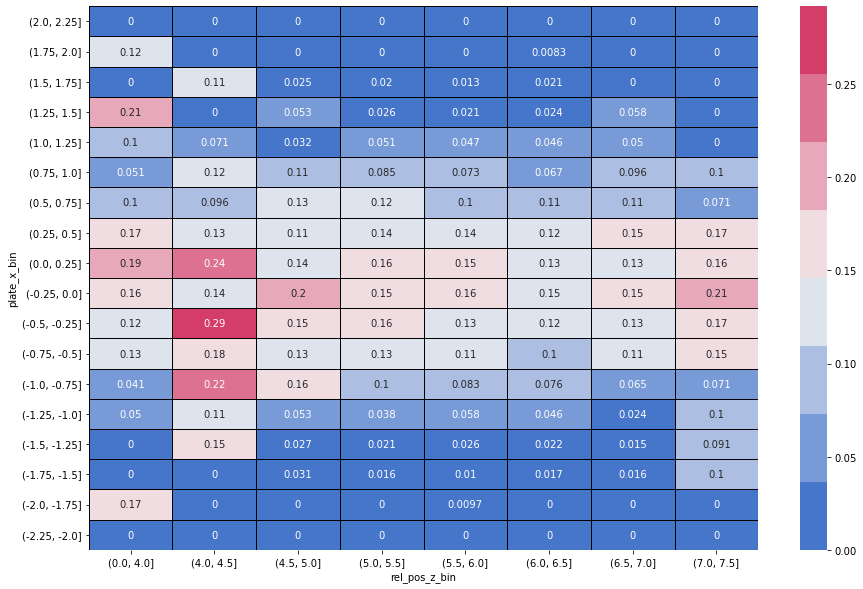

In [202]:
#fastballs['rel_pos_z_bin'] = pd.cut(fastballs['release_pos_z'], bins = rel_pos_z)
#fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
#fastballs['plate_z_bin'] = pd.cut(fastballs['plate_z'], bins = vert_sz_bins)
##fastballs['plate_x_bin'] = pd.cut(fastballs['plate_x'], bins = hor_sz_bins)
#fastballs['pfx_z_bin'] = pd.cut(fastballs['pfx_z'],bins = cut_bins_pfz)
#fastballs['vaa_bin'] = pd.cut(fastballs['vaa'], bins = vaa_bins)

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=8)

g = sns.heatmap(x, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)
g.invert_yaxis()
#g.add_patch(Rectangle((6,5),6,8, fill= False, edgecolor = 'black', lw = 5))


In [186]:
fastballs23up = fastballs23.loc[fastballs23['plate_z'] > 2.8]
fastballs22up = fastballs22.loc[fastballs22['plate_z'] > 2.8]

In [209]:
#### find fastballs that are high and tight to a batter

a1 = []


for i in range(len(fastballs23up)):
        
    stand = fastballs23up.iloc[i]['stand']
    vert_loc = fastballs23up.iloc[i]['plate_z']
    hor_loc = fastballs23up.iloc[i]['plate_x']
    szT = fastballs23up.iloc[i]['sz_top']
    szB = fastballs23up.iloc[i]['sz_bot']
    szUpLim = szT + .5
    szBotLim = szT - .5
    
    
    if stand == 'R':
        szLim1 = -.35
        szLim2 = -1.15
    else:
        szLim1 = .35
        szLim2 = 1.15
    
            
    if (vert_loc > szBotLim) and (vert_loc < szUpLim) and (hor_loc > szLim1) and (hor_loc < szLim2):
        j = 1
    else:
        j = 0
        
    #print(j)
        
    a1.append(j)
    
    
a2 = []


for i in range(len(fastballs22up)):
        
    stand = fastballs22up.iloc[i]['stand']
    vert_loc = fastballs22up.iloc[i]['plate_z']
    hor_loc = fastballs22up.iloc[i]['plate_x']
    szT = fastballs22up.iloc[i]['sz_top']
    szB = fastballs22up.iloc[i]['sz_bot']
    szUpLim = szT + .5
    szBotLim = szT - .5
    
    
    if stand == 'R':
        szLim1 = -.35
        szLim2 = -1.15
    else:
        szLim1 = .35
        szLim2 = 1.15
    
            
    if (vert_loc > szBotLim) and (vert_loc < szUpLim) and (hor_loc > szLim1) and (hor_loc < szLim2):
        j = 1
    else:
        j = 0
        
    #print(j)
        
    a2.append(j)


In [210]:
fastballs23up['plus_loc'] = a1
fastballs22up['plus_loc'] = a2

C:\Users\NPACCH~1\AppData\Local\Temp/ipykernel_22940/1049751836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs23up['plus_loc'] = a1
C:\Users\NPACCH~1\AppData\Local\Temp/ipykernel_22940/1049751836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs22up['plus_loc'] = a2
